# Star Spots Tutorial

In this tutorial, we will go over how to use spots in `VSPEC`

In [1]:
import VSPEC
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

### What are spots?

Star spots are cool regions of the stellar surface caused by magnetic activity. They appear dark compared to the surrounding photosphere.

The `VSPEC` spot model is based on observations of sunspots, but we allow the user to alter much of their behavior by changing default parameters.  
For example, our model by default assumes spots consist of a cool penumbra surrounding an even cooler umbra. However, it is possible to create single-temperature spots.  
Also, spots by default grow and decay on timescales of weeks. However, observations of M-dwarfs suggest that spots on cooler stars can live for many years. In this case, the user can disable spot aging.

Let's create a typical spot.

In [2]:
spot = VSPEC.variable_star_model.StarSpot(
    lat=0*u.deg, # central latitude
    lon=180*u.deg, # central longitude
    Amax=500*VSPEC.helpers.MSH, # maximum area
    A0=200*VSPEC.helpers.MSH, # current area
    Teff_penumbra=2700*u.K, # Teff of penumbra
    Teff_umbra=2500*u.K, # Teff of umbra
    r_A = 5., # ratio total area / umbra area
    growing = True, # is it still growing?
    growth_rate = 0.5/u.day, # rate of exponential growth
    decay_rate = 10*VSPEC.helpers.MSH/u.day, # rate of constant decay
    Nlat = 500, # number of latitude points
    Nlon = 1000 # number of longitude points
)

Upon initialiation, every `StarSpot` creates two new attributes behind the scenes.

First, it creates a `gridmaker` attribute that is a `VSPEC.helpers.CoordinateGrid` object. This just helps standardize the stellar surface map across different variability sources.

It also creates a map of the stellar surface, calculating the angular distance to every point. For fine grids, this is can use a lot of memory, but it is better to store these after initialization than to redo the calculation each time we want to know which points are included in the spot. This is the `r` attribute.

Let's plot the distance map as well as an outline of the spot.

Text(0, 0.5, 'lat (deg)')

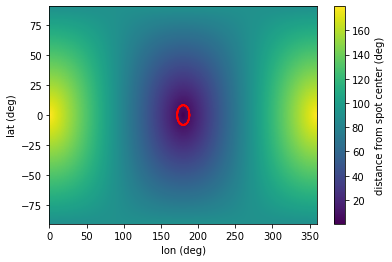

In [3]:
lat,lon = spot.gridmaker.oned()
plt.pcolormesh(lon.value,lat.value,VSPEC.helpers.to_float(spot.r,u.deg).T)
plt.colorbar(label='distance from spot center (deg)')
r_star = 0.14*u.R_sun
rad = spot.angular_radius(r_star)
plt.contour(lon.value,lat.value,spot.r.T < rad,colors='r')
plt.xlabel('lon (deg)')
plt.ylabel('lat (deg)')

These two methods are combined to create a pixel map of the stellar effective temperature according to this spot. The figure below shows the regions of the surface that are part of the quiet photosphere, penumbra, and umbra.

Text(0, 0.5, 'lat (deg)')

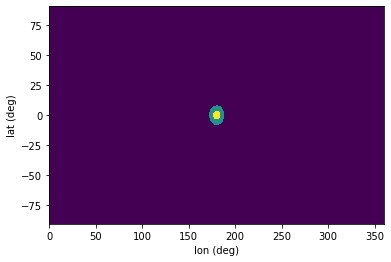

In [4]:
r_star = 0.14*u.R_sun
pixmaps = spot.map_pixels(r_star)
umbra = pixmaps[spot.Teff_umbra].astype('int')
penumbra = pixmaps[spot.Teff_penumbra].astype('int')
lat,lon = spot.gridmaker.oned()
plt.pcolormesh(lon.value,lat.value,(umbra+penumbra).T)
plt.xlabel('lon (deg)')
plt.ylabel('lat (deg)')

For small spots, we can also calculate a 2D approximation of their coverage fractions using the `surface_fraction()` method. This approximation is valid for any viewing angle, but starts to break down as the spot radius is similar to the radius of the star. `VSPEC` does not use this method when calculating stellar spectra, but it can be useful in testing and demonstrations.

Text(0, 0.5, 'Surface Coverage Fraction')

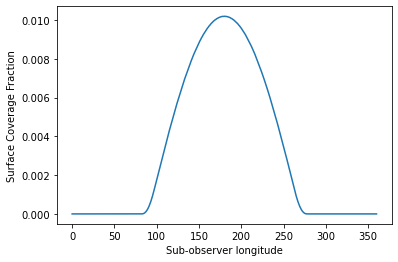

In [5]:
r_star = 0.14*u.R_sun
sub_obs = {'lat':0*u.deg,'lon':0*u.deg}
data = []
lons = np.linspace(0,360,361)*u.deg
for lon in lons:
    sub_obs['lon']=lon
    data.append(spot.surface_fraction(sub_obs,r_star))

plt.plot(lons,data)
plt.xlabel('Sub-observer longitude')
plt.ylabel('Surface Coverage Fraction')

`VSPEC` uses a numerical integral to calculate this quantity in order to properly handle cases where the spot is on the limb of the stellar disk and only partially visible.

